In [2]:
import h5py
import numpy as np
import pandas as pd
import preprocess_utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import glob
import cv2
import shutil
import random
import scipy

Number of Events: 4599
Shape: (3, 2500), Dtype: float64


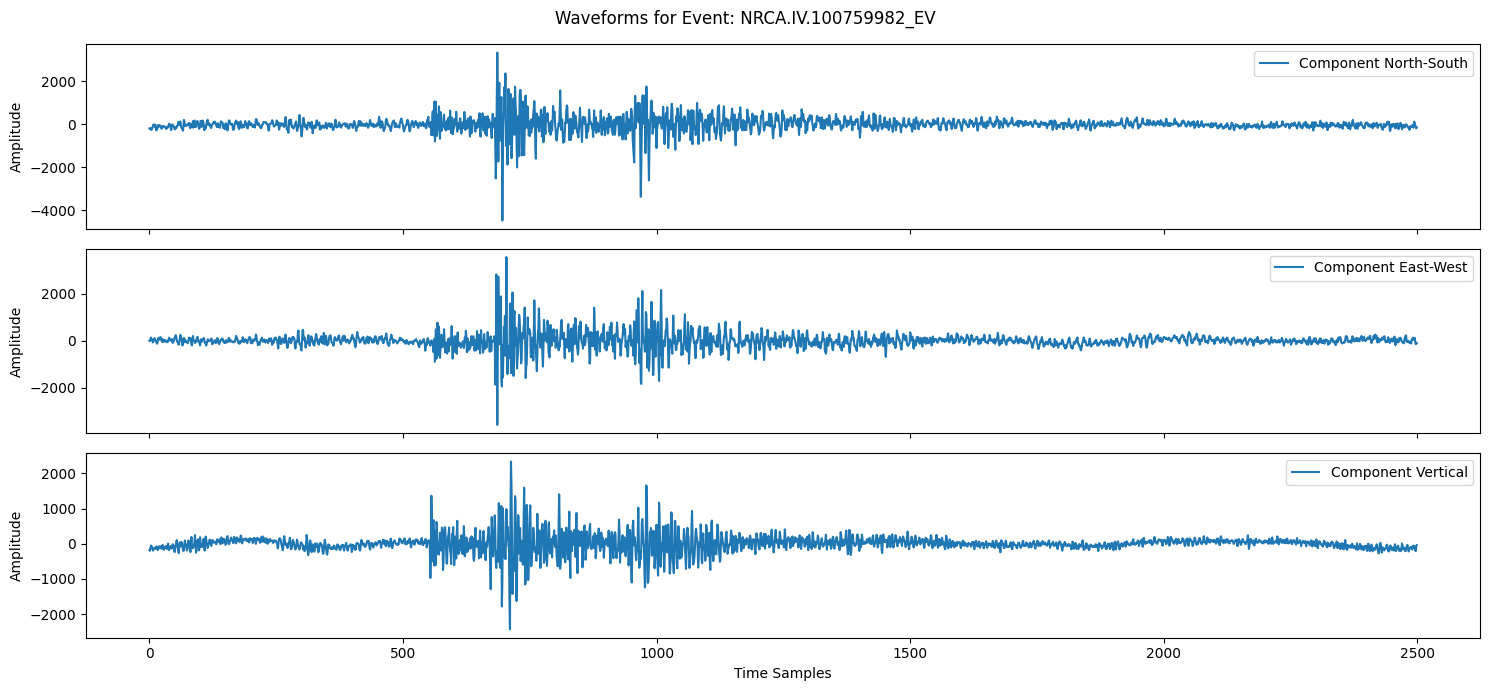

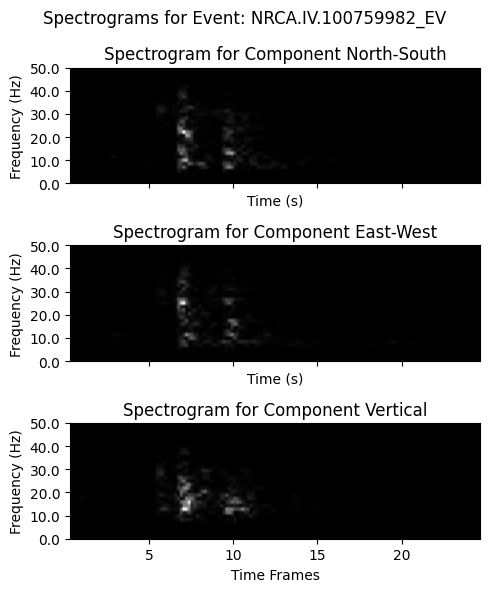

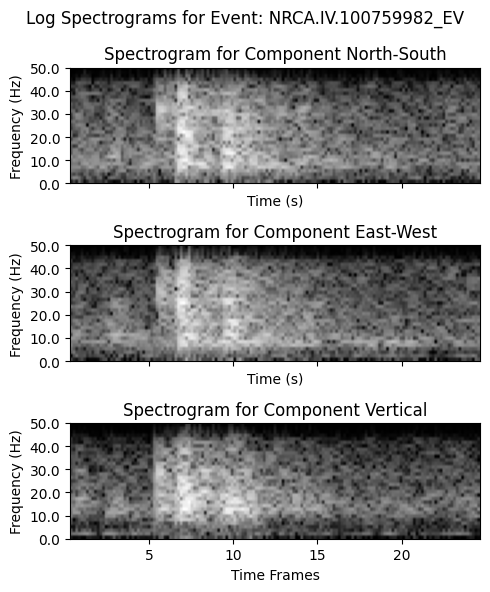

In [4]:
# Open the HDF5 file
file_path = r"E:\EQML_Project\data\dataset\NRCA\NRCA_waveforms_pre.hdf5"  # Replace with the path to your file
with h5py.File(file_path, 'r') as hdf:
    # List all events in the HDF5 file
    events = list(hdf.keys())
    print(f"Number of Events: {len(events)}")
    
    # Access the first event
    event = events[4161]  # Take the first waveform
    waveforms = hdf[event]  # Access the dataset for this event
    
    # Check the shape and details of the dataset
    print(f"Shape: {waveforms.shape}, Dtype: {waveforms.dtype}")
    # Shape should be (3, 2500), Dtype: float64 for three components

    # Plot the waveforms
    fig, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=True)
    component_names = ['North-South', 'East-West', 'Vertical']
    
    for i in range(3):
        axes[i].plot(waveforms[i], label=f"Component {component_names[i]}")
        axes[i].set_ylabel("Amplitude")
        axes[i].legend(loc="upper right")
    
    axes[-1].set_xlabel("Time Samples")
    plt.suptitle(f"Waveforms for Event: {event}")
    plt.tight_layout()
    plt.show()

    # Create a three-channel spectrogram
    spectrograms, f, t = preprocess_utils.compute_spectrograms(waveforms)
    log_spectrograms, log_f, log_t = preprocess_utils.compute_log_spectrograms(waveforms)
    # Assuming utils.compute_spectrograms returns a 3D array (components, frequency_bins, time_frames)
    fig, axes = plt.subplots(3, 1, figsize=(5, 6), sharex=True)

    for i in range(3):
        im = axes[i].imshow(spectrograms[i], aspect='auto', cmap='gray', origin='lower', extent=[t[0], t[-1], f[0], f[-1]])
        axes[i].set_ylabel("Frequency (Hz)")
        axes[i].set_title(f"Spectrogram for Component {component_names[i]}")
        axes[i].set_xlabel("Time (s)")
        axes[i].set_yticks(np.linspace(f[0], f[-1], num=6))  # Adjust number of ticks as needed
        axes[i].set_yticklabels([f"{freq:.1f}" for freq in np.linspace(f[0], f[-1], num=6)])  # Format frequency labels

    axes[-1].set_xlabel("Time Frames")
    plt.suptitle(f"Spectrograms for Event: {event}")
    plt.tight_layout()
    plt.show()

    # Assuming utils.compute_log_spectrograms returns a 3D array (components, frequency_bins, time_frames)
    fig, axes = plt.subplots(3, 1, figsize=(5, 6), sharex=True)

    for i in range(3):
        im = axes[i].imshow(log_spectrograms[i], aspect='auto', cmap='gray', origin='lower', extent=[t[0], log_t[-1], log_f[0], log_f[-1]])
        axes[i].set_ylabel("Frequency (Hz)")
        axes[i].set_title(f"Spectrogram for Component {component_names[i]}")
        axes[i].set_xlabel("Time (s)")
        axes[i].set_yticks(np.linspace(f[0], f[-1], num=6))  # Adjust number of ticks as needed
        axes[i].set_yticklabels([f"{freq:.1f}" for freq in np.linspace(f[0], f[-1], num=6)])  # Format frequency labels

    axes[-1].set_xlabel("Time Frames")
    plt.suptitle(f"Log Spectrograms for Event: {event}")
    plt.tight_layout()
    plt.show()



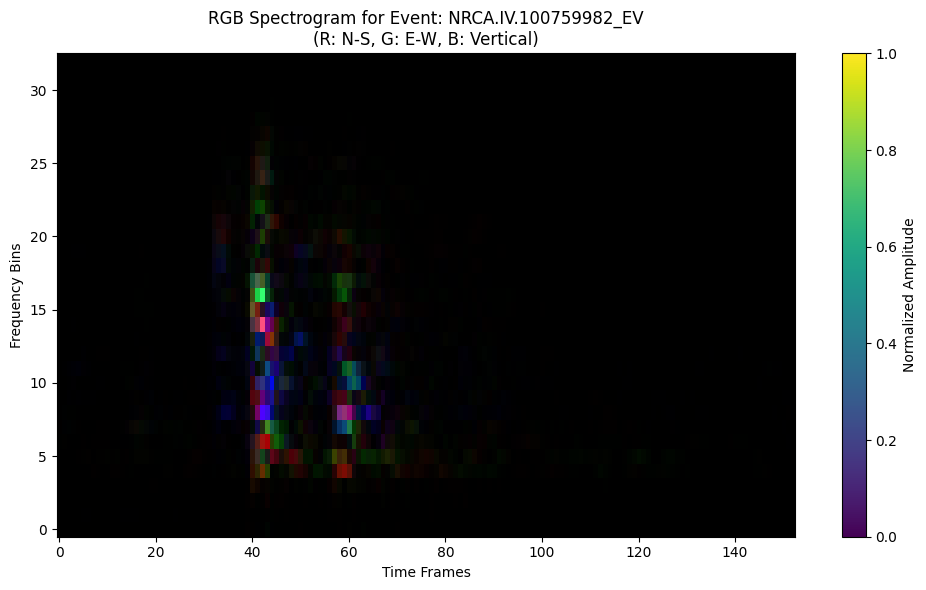

In [27]:
# Normalize each channel to [0,1] range for RGB visualization
rgb_spec = np.zeros((spectrograms.shape[1], spectrograms.shape[2], 3))

for i in range(3):
    channel = spectrograms[i]
    # Normalize between 0 and 1
    channel_norm = (channel - channel.min()) / (channel.max() - channel.min())
    rgb_spec[:,:,i] = channel_norm

# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(rgb_spec, aspect='auto', origin='lower')
plt.colorbar(label='Normalized Amplitude')
plt.ylabel('Frequency Bins')
plt.xlabel('Time Frames')
plt.title(f'RGB Spectrogram for Event: {event}\n(R: N-S, G: E-W, B: Vertical)')
plt.tight_layout()
plt.show()

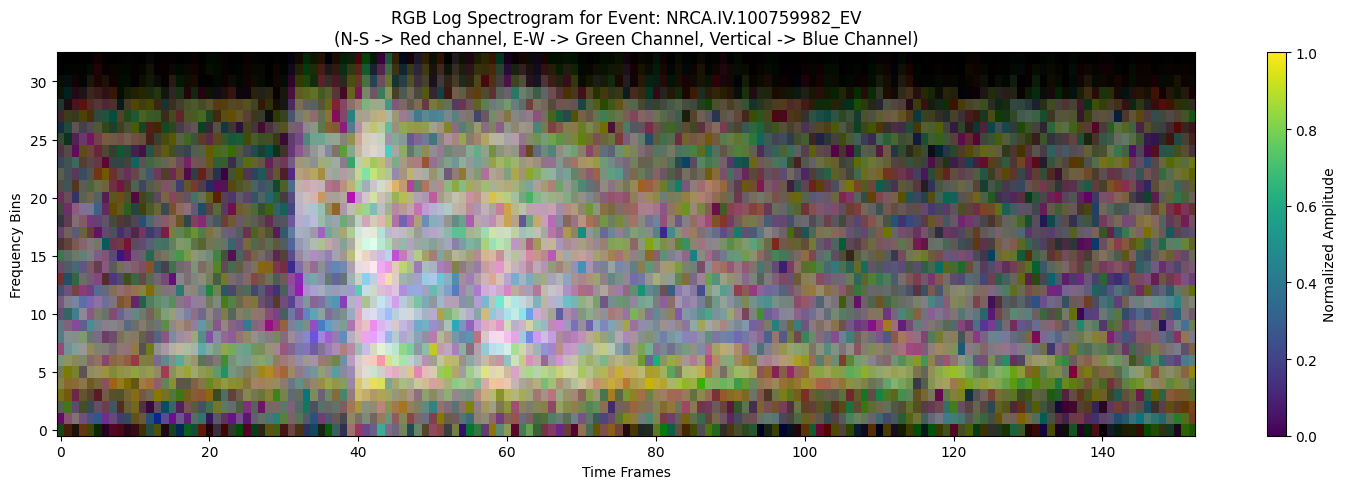

In [34]:
# Normalize each channel to [0,1] range for RGB visualization
rgb_log_spec = np.zeros((log_spectrograms.shape[1], log_spectrograms.shape[2], 3))

for i in range(3):
    channel = log_spectrograms[i]
    # Normalize between 0 and 1
    channel_norm = (channel - channel.min()) / (channel.max() - channel.min())
    rgb_log_spec[:,:,i] = channel_norm

# Create the plot
plt.figure(figsize=(15, 5))
plt.imshow(rgb_log_spec, aspect='auto', origin='lower')
plt.colorbar(label='Normalized Amplitude')
plt.ylabel('Frequency Bins')
plt.xlabel('Time Frames')
plt.title(f'RGB Log Spectrogram for Event: {event}\n(N-S -> Red channel, E-W -> Green Channel, Vertical -> Blue Channel)')
plt.tight_layout()
plt.show()

In [ ]:
# Get all HDF5 files that end with _pre.hdf5 or _post.hdf5 in all subfolders
base_path = r"E:\EQML_Project\data\dataset"
hdf5_files = glob.glob(base_path + "/**/*_pre.hdf5", recursive=True) + glob.glob(base_path + "/**/*_post.hdf5", recursive=True)
output_dir = r"E:\EQML_Project\data_preprocessed\log_spectrograms"
os.makedirs(output_dir, exist_ok=True)

# Process each file
for file_path in hdf5_files:
    os.makedirs(output_dir, exist_ok=True)
    print(f"Processing file: {file_path}")
    
    with h5py.File(file_path, 'r') as hdf:
        events = list(hdf.keys())
        for event in tqdm(events, desc=f"Processing {os.path.basename(file_path)}", leave=False):
            try:
                # Get waveforms for this event
                waveforms = hdf[event]
                label = file_path.split('.')[0].split('_')[-1]
                
                # Compute log spectrograms
                log_spectrograms, _, _ = preprocess_utils.compute_log_spectrograms(waveforms)
                
                # Create RGB image
                rgb_spec = np.zeros((log_spectrograms.shape[1], log_spectrograms.shape[2], 3))
                for i in range(3):
                    channel = log_spectrograms[i]
                    channel_norm = (channel - channel.min()) / (channel.max() - channel.min())
                    rgb_spec[:,:,i] = channel_norm
                    
                # Save as PNG file
                output_path = os.path.join(output_dir, f"{event}_{label}.png")
                plt.imsave(output_path, rgb_spec)
            except Exception as e:
                print(f"Error processing event {event} in file {file_path}: {e}")

In [ ]:
# Get all HDF5 files that end with _pre.hdf5 or _post.hdf5 in all subfolders
base_path = r"E:\EQML_Project\data\dataset"
hdf5_files = glob.glob(base_path + "/**/*_pre.hdf5", recursive=True) + glob.glob(base_path + "/**/*_post.hdf5", recursive=True)
output_dir = r"E:\EQML_Project\data_preprocessed\spectrograms"
os.makedirs(output_dir, exist_ok=True)

# Process each file
for file_path in hdf5_files:
    os.makedirs(output_dir, exist_ok=True)
    print(f"Processing file: {file_path}")
    
    with h5py.File(file_path, 'r') as hdf:
        events = list(hdf.keys())
        for event in tqdm(events, desc=f"Processing {os.path.basename(file_path)}", leave=False):
            try:
                # Get waveforms for this event
                waveforms = hdf[event]
                label = file_path.split('.')[0].split('_')[-1]
                
                # Compute log spectrograms
                spectrograms, _, _ = preprocess_utils.compute_spectrograms(waveforms)
                
                # Create RGB image
                rgb_spec = np.zeros((spectrograms.shape[1], spectrograms.shape[2], 3))
                for i in range(3):
                    channel = spectrograms[i]
                    channel_norm = (channel - channel.min()) / (channel.max() - channel.min())
                    rgb_spec[:,:,i] = channel_norm
                    
                # Save as PNG file
                output_path = os.path.join(output_dir, f"{event}_{label}.png")
                plt.imsave(output_path, rgb_spec)
            except Exception as e:
                print(f"Error processing event {event} in file {file_path}: {e}")

In [ ]:
# Set random seed for reproducibility
random.seed(42)

# Define paths
base_dir = r"E:\EQML_Project\data_preprocessed\log_spectrograms"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid") 
test_dir = os.path.join(base_dir, "test")

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of image files (excluding mean_image.png)
image_files = [f for f in os.listdir(base_dir) if f.endswith('.png') and f != 'mean_image.png']

# Shuffle files randomly
random.shuffle(image_files)

# Calculate split indices
total_files = len(image_files)
train_split = int(0.7 * total_files)
valid_split = int(0.15 * total_files)

# Split files into train, valid, test
train_files = image_files[:train_split]
valid_files = image_files[train_split:train_split + valid_split]
test_files = image_files[train_split + valid_split:]

# Move files to respective directories
for f in train_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(train_dir, f))

for f in valid_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(valid_dir, f))
    
for f in test_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(test_dir, f))

print(f"Split {len(train_files)} training, {len(valid_files)} validation, {len(test_files)} test images")

Split 55617 training, 11918 validation, 11919 test images


In [20]:
# Set random seed for reproducibility
random.seed(42)

# Define paths
base_dir = r"E:\EQML_Project\data_preprocessed\spectrograms"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid") 
test_dir = os.path.join(base_dir, "test")

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of image files (excluding mean_image.png)
image_files = [f for f in os.listdir(base_dir) if f.endswith('.png') and f != 'mean_image.png']

# Shuffle files randomly
random.shuffle(image_files)

# Calculate split indices
total_files = len(image_files)
train_split = int(0.7 * total_files)
valid_split = int(0.15 * total_files)

# Split files into train, valid, test
train_files = image_files[:train_split]
valid_files = image_files[train_split:train_split + valid_split]
test_files = image_files[train_split + valid_split:]

# Move files to respective directories
for f in train_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(train_dir, f))

for f in valid_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(valid_dir, f))
    
for f in test_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(test_dir, f))

print(f"Split {len(train_files)} training, {len(valid_files)} validation, {len(test_files)} test images")

Split 55617 training, 11918 validation, 11919 test images


In [6]:

# Path to spectrogram images
image_dir = r"E:\EQML_Project\data_preprocessed\log_spectrograms\train"
image_files = glob.glob(os.path.join(image_dir, "*.png"))

# Initialize variables for mean calculation
sum_image = None
count = 0

# Process images in batches
for image_path in tqdm(image_files, desc="Calculating mean image"):
    try:
        # Read image
        img = cv2.imread(image_path)
        
        if sum_image is None:
            sum_image = np.zeros_like(img, dtype=np.float64)
            
        # Add to sum
        sum_image += img
        count += 1
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Calculate mean
if count > 0:
    mean_image = (sum_image / count).astype(np.uint8)
    
    # Save mean image
    mean_image_path = os.path.join(r"E:\EQML_Project\data_preprocessed\log_spectrograms\train\mean\mean.png")
    cv2.imwrite(mean_image_path, mean_image)
    print(f"Mean image saved to {mean_image_path}")
else:
    print("No images were processed")

Calculating mean image: 100%|██████████| 55617/55617 [00:31<00:00, 1744.83it/s]

Mean image saved to E:\EQML_Project\data_preprocessed\log_spectrograms\train\mean\mean.png


In [7]:

# Path to spectrogram images
image_dir = r"E:\EQML_Project\data_preprocessed\spectrograms\train"
image_files = glob.glob(os.path.join(image_dir, "*.png"))

# Initialize variables for mean calculation
sum_image = None
count = 0

# Process images in batches
for image_path in tqdm(image_files, desc="Calculating mean image"):
    try:
        # Read image
        img = cv2.imread(image_path)
        
        if sum_image is None:
            sum_image = np.zeros_like(img, dtype=np.float64)
            
        # Add to sum
        sum_image += img
        count += 1
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Calculate mean
if count > 0:
    mean_image = (sum_image / count).astype(np.uint8)
    
    # Save mean image
    mean_image_path = os.path.join(r"E:\EQML_Project\data_preprocessed\spectrograms\train\mean\mean.png")
    cv2.imwrite(mean_image_path, mean_image)
    print(f"Mean image saved to {mean_image_path}")
else:
    print("No images were processed")

Calculating mean image: 100%|██████████| 55617/55617 [01:46<00:00, 520.53it/s] 

Mean image saved to E:\EQML_Project\data_preprocessed\spectrograms\train\mean\mean.png


In [2]:
# Define base path for HDF5 and CSV files
base_path = r"E:\EQML_Project\data\dataset"

# Get all HDF5 files
hdf5_files = glob.glob(base_path + "/**/*_pre.hdf5", recursive=True) + glob.glob(base_path + "/**/*_post.hdf5", recursive=True)

# Initialize list to store all data
all_data = []

# Function to determine the corresponding CSV file for an HDF5 file
def get_csv_file(hdf5_file):
    base_name = os.path.basename(hdf5_file).replace("waveforms", "attributes").replace(".hdf5", ".csv")
    csv_file = os.path.join(os.path.dirname(hdf5_file), base_name)
    return csv_file

# Process each HDF5 file
for hdf5_file in hdf5_files:
    csv_file = get_csv_file(hdf5_file)
    
    if not os.path.exists(csv_file):
        print(f"Corresponding CSV file not found for {hdf5_file}")
        continue
    
    # Read metadata CSV
    metadata_df = pd.read_csv(csv_file)
    
    # Open HDF5 file
    with h5py.File(hdf5_file, 'r') as hdf:
        events = list(hdf.keys())
        
        # Process each event
        for event in tqdm(events, desc=f"Processing {os.path.basename(hdf5_file)}"):
            try:
                # Get waveforms
                waveforms = hdf[event]
                
                # Calculate features for each component
                features = preprocess_utils.extract_waveform_features(waveforms)
                
                # Find corresponding metadata row
                metadata_row = metadata_df[metadata_df['trace_name'] == event].copy()
                if not metadata_row.empty:
                    # Add features to metadata
                    for feature_name, feature_value in features.items():
                        metadata_row[feature_name] = feature_value
                    all_data.append(metadata_row)
                    
            except Exception as e:
                print(f"Error processing event {event} in file {hdf5_file}: {e}")

# Combine all data
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)

    # Save to CSV
    output_path = r"E:\EQML_Project\data_preprocessed\metadata_with_features.csv"
    final_df.to_csv(output_path, index=False)
    print(f"Saved metadata with features to {output_path}")
else:
    print("No data was processed.")


Processing NRCA_waveforms_pre.hdf5:   7%|▋         | 331/4599 [00:11<01:58, 35.88it/s]

Error processing event NRCA.IV.100019941_EV in file E:\EQML_Project\data\dataset\NRCA\NRCA_waveforms_pre.hdf5: Index (1) out of range for (0-0)
Error processing event NRCA.IV.100019946_EV in file E:\EQML_Project\data\dataset\NRCA\NRCA_waveforms_pre.hdf5: Index (1) out of range for (0-0)
Error processing event NRCA.IV.100019950_EV in file E:\EQML_Project\data\dataset\NRCA\NRCA_waveforms_pre.hdf5: Index (1) out of range for (0-0)


Processing NRCA_waveforms_pre.hdf5:  69%|██████▉   | 3185/4599 [02:13<00:49, 28.58it/s]

Error processing event NRCA.IV.100709001_EV in file E:\EQML_Project\data\dataset\NRCA\NRCA_waveforms_pre.hdf5: Index (2) out of range for (0-1)


Processing FDMO_waveforms_post.hdf5:  67%|██████▋   | 3413/5107 [01:51<00:50, 33.62it/s]

Error processing event FDMO.IV.100442345_EV in file E:\EQML_Project\data\dataset\FDMO\FDMO_waveforms_post.hdf5: Index (1) out of range for (0-0)


Processing FDMO_waveforms_post.hdf5:  72%|███████▏  | 3690/5107 [01:59<00:42, 33.57it/s]

Error processing event FDMO.IV.100460684_EV in file E:\EQML_Project\data\dataset\FDMO\FDMO_waveforms_post.hdf5: Index (1) out of range for (0-0)


Processing FDMO_waveforms_post.hdf5:  99%|█████████▉| 5045/5107 [02:40<00:01, 36.05it/s]

Error processing event FDMO.IV.100583482_EV in file E:\EQML_Project\data\dataset\FDMO\FDMO_waveforms_post.hdf5: Index (1) out of range for (0-0)


Processing T1244_waveforms_post.hdf5: 100%|██████████| 4317/4317 [02:11<00:00, 32.80it/s]


Saved metadata with features to E:\EQML_Project\data_preprocessed\metadata_with_features.csv
